# Piecewise linear functions on triangulations

We test the two OMP algorithm on functions in two dimensions, $[0,1]^2$, that is we take $V = H_0^1([0,1]^2)$.

Here the unknown $u$ is a solution to the usual diffusion PDE with a dyadic piecewise constant random field.

We consider a dyadic level-$N$ uniform grid with spacing $\Delta x_{(N)} = 2^{-N}$. The solution is computed on the regular triangulation on this grid, evidently with $h=2^{-N}$. The field $a$ is a pw-constant function on a typically coarser grid, with spacing say $2^{-N_a}$, where $N_a \le N$. 

The dictionary $\mathcal{D}$ for the OMP algorithms consists of the representers of local integration, where the kernel for the local integration are hat-functions. The hat functions we consider are on the squares of size $2^{-N_\mathrm{hat}}$, again with $N_{\mathrm{hat}} \le N$.

That is, if $\mathrm{Hat}_{i,j}$ is the pw linear hat function on the square $[i 2^{-N_{\mathrm{hat}}}, (i+1) 2^{-N_{\mathrm{hat}}}) \times [j 2^{-N_{\mathrm{hat}}}, (j+1) 2^{-N_{\mathrm{hat}}})$, then $\mathcal{D}^{\mathrm{hat}}$ is the collection of functions $\omega_{i,j}$ such that
$$
\langle f, \omega_{i,j}\rangle_{H_0^1} = \int_{[0,1]^2} f \, \mathrm{Hat}_{i,j} \, \mathrm{d}x
$$

In [1]:
import numpy as np
import scipy as sp
import math
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Demonstration of point evals and projections in 2D

In [2]:
fem_div = 7
field_div = 2

a_bar = 1.0
c = 0.9
np.random.seed(3)
a = pat.PWConstantSqDyadicL2(a_bar + c * (2.0 * np.random.random([2**field_div, 2**field_div]) - 1.0), field_div)
b = a.interpolate(fem_div)
fem = pat.DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)
fem.solve()

m = 20
np.random.seed(17)
Wm = pat.make_pw_random_local_integration_basis(m, div=fem_div)
u_W = Wm.project(fem.u)

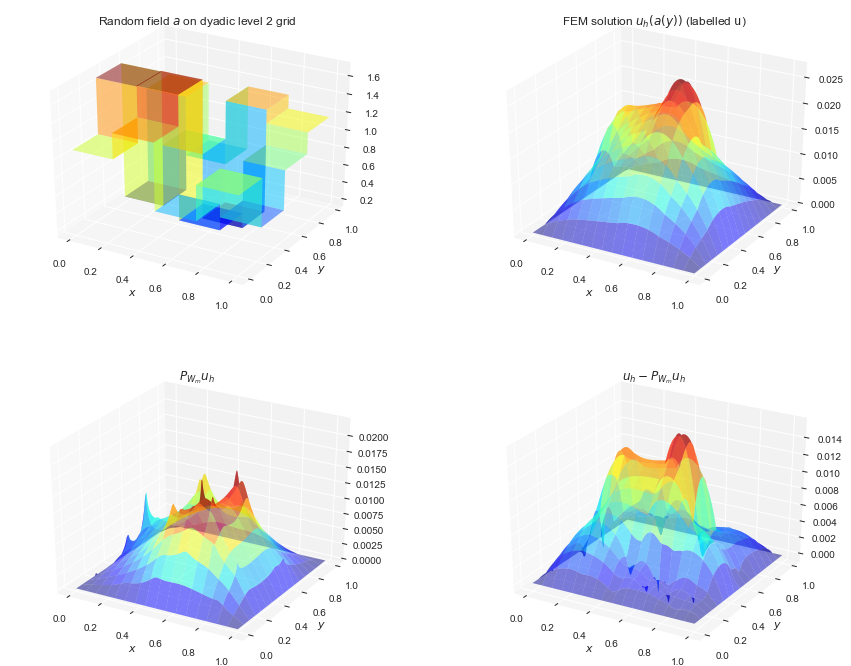

In [3]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(2, 2, 1, projection='3d')
a.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(2, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u}$)')
ax = fig.add_subplot(2, 2, 3, title=r'$P_{W_m} u_h$', projection='3d')
u_W.plot(ax)
ax = fig.add_subplot(2, 2, 4, title=r'$u_h - P_{W_m} u_h$', projection='3d')
(fem.u - u_W).plot(ax)
plt.show()

### Now we are going to set up a full dictionary of local integration points

And look at projection errors as we decrease the width and the spacing

Projection errors for width 1, spacing: 1, 

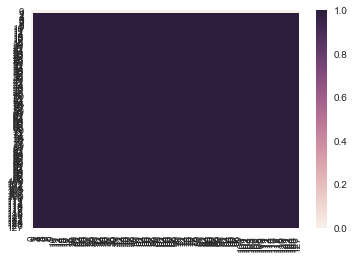

KeyboardInterrupt: 

In [4]:
n = 20
m = 100

widths = [2**i for i in range(fem_div-1)]

# Create Vn - an orthonormalised reduced basis
Vn, fields = pat.make_pw_reduced_basis(n, field_div=2, fem_div=fem_div)
Vn = Vn.orthonormalise()

Wms = []
bs = np.zeros((len(widths), m))
p_err = np.zeros((len(widths), 2**(fem_div-2)+1))
for j, width in enumerate(widths):
    print('Projection errors for width ' + str(width) + ', spacing: ', end='')
    for i, spacing in enumerate(range(math.ceil(width/2), 2**(fem_div-2)+1)):
        print(str(spacing) + ', ', end='')
        B = pat.make_local_integration_basis(width, spacing, fem_div)
        # Ok, lets look at projection errors
        u_W = B.project(fem.u)
        p_err[j, spacing] = (fem.u - u_W).norm()
        
    print('Greedy basis construction...')
    spacing = width#int(width/2)
    B = pat.make_local_integration_basis(width, spacing, fem_div)
    # Now we do the greedy construction from the dictionary
    if B.n > m:
        wcbc = pat.WorstCaseOMP(m, B.vecs, Vn, Wm=pat.PWBasis(), verbose=True)
        Wm = wcbc.construct_basis()
        Wms.append(Wm)
        Wm_o = Wm.orthonormalise()

        # For efficiency it makes sense to compute the basis pair and the associated
        # cross-gramian only once, then sub sample it as we grow m...
        BP_l = pat.BasisPair(Wm_o, Vn)

        for i in range(n, m):
            BP =  BP_l.subspace(Wm_indices=slice(0,i))
            bs[j, i] = BP.beta()
    

In [ ]:

pals = ['Blues_r', 'Greens_r', 'Reds_r']
axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title='Projection error')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')
for i, n in enumerate(widths):
    plt.plot(range(2**(fem_div-2)+1), p_err[i,:], label=r'$\| P v - v \|$')

sns.set_palette(pals[0])
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title='Projection error')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')
for i in range(2**(fem_div-2)+1):
    plt.plot(widths[(p_err[:,i]>0)], p_err[(p_err[:,i]>0),i], 'x-', label=r'spacing = {0}'.format(i))
plt.legend()    
plt.show()

#pdb.set_trace()

"""
ax.set(xlabel='m', ylabel='beta(Vn, Wm)')#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.show()

fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title='beta(Vn, Wm) against m for various n')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')
for i, n in enumerate(ns):
    sns.set_palette(pals[i])
    cp = sns.color_palette()
    for k, dictionary in enumerate(dictionaries):
        plt.plot(range(m), bs_comp[i, :, k], '--', label=r'collective omp Wm for n={0}, {1}, Collective OMP'.format(n, dict_label[k]), color=cp[2*k+1])
    plt.plot(range(m), bs_rand[i, :], '-.', label=r'random Wm for n={0}'.format(n), color=cp[k], lw=1)

ax.set(xlabel='m', ylabel='beta(Vn, Wm)')#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.show()"""